In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [3]:
data_train

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0
...,...,...,...,...
60482,275,115360,552,0
60483,275,115912,552,0
60484,275,116464,552,0
60485,275,117020,556,0


In [4]:
max_x_threshold = 1100
min_x_threshold = 400
data_train = data_train[data_train.x < max_x_threshold]
data_train = data_train[data_train.x > min_x_threshold]

In [5]:
data_train.index = list(range(len(data_train)))

In [6]:
split_id = 200
train = data_train[data_train.id < split_id]
test = data_train[data_train.id >= split_id]

In [7]:
print('Train len: ', len(train.id.unique()))
print('Test len: ', len(test.id.unique()))

Train len:  166
Test len:  63


### CNN

#### Data preparation

In [8]:
spikes_regions = {}
c = 1
for i in range(1,len(train)):
    if train.iloc[i-1].y == 0 and train.iloc[i].y == 1:
        coord = [i]
    if train.iloc[i-1].y == 1 and train.iloc[i].y == 1:
        c+=1
    if train.iloc[i-1].y == 1 and train.iloc[i].y == 0:
        coord.append(i-1)
        if train.iloc[i-1].id in spikes_regions.keys():
            spikes_regions[train.iloc[i-1].id].append(c)
            spikes_regions[train.iloc[i-1].id].append(coord)
        else:
            spikes_regions[train.iloc[i-1].id] = [c]
            spikes_regions[train.iloc[i-1].id] = [coord]
        c = 1

In [9]:
spikes_regions

{1: [[322, 335], 14, [722, 735], 11, [1338, 1348]],
 2: [[1864, 1872], 10, [1969, 1978], 8, [1990, 1997], 10, [2031, 2040]],
 3: [[2047, 2055], 9, [2096, 2104], 10, [2107, 2116], 12, [2133, 2144]],
 4: [[2153, 2172], 9, [2198, 2206], 10, [2217, 2226]],
 5: [[2343, 2351], 9, [2372, 2380], 12, [2428, 2439], 11, [2451, 2461]],
 6: [[2484, 2494], 11, [2541, 2551], 12, [2568, 2579], 10, [2620, 2629]],
 7: [[2653, 2664], 10, [2674, 2683], 11, [2738, 2748]],
 10: [[2799, 2806], 22, [2817, 2838], 6, [2842, 2847]],
 12: [[2871, 2880], 12, [2896, 2907], 11, [2964, 2974]],
 13: [[2986, 2994], 8, [3122, 3129], 18, [3139, 3156]],
 14: [[3195, 3202], 14, [3216, 3229], 8, [3395, 3402], 10, [3412, 3421]],
 15: [[3453, 3460], 7, [3465, 3471], 8, [3526, 3533], 9, [3599, 3607]],
 16: [[3620, 3630], 9, [3658, 3666], 7, [3699, 3705], 8, [3758, 3765]],
 17: [[3829, 3837], 8, [3853, 3860], 13, [3874, 3886], 17, [4001, 4017]],
 19: [[4065, 4074], 8, [4119, 4126], 14, [4249, 4262]],
 20: [[4852, 4859], 8, [496

     id    time    x  y
322   1  272904  716  1
323   1  273620  716  1
324   1  274340  720  1
325   1  275060  720  1
326   1  275776  716  1
327   1  276484  708  1
328   1  277200  716  1
329   1  277924  724  1
330   1  278656  732  1
331   1  279440  784  1
332   1  280104  664  1
333   1  280808  704  1
334   1  281504  696  1
335   1  282200  696  1


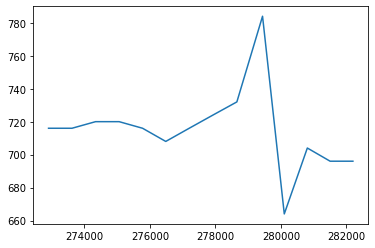

In [10]:
frame = data_train.loc[322:335]
print(frame)
plt.plot(frame.time, frame.x)

In [7]:
def create_cnn_data(df, frame_len=10, offset=0, spike_threshold=7):
    cnn_data = pd.DataFrame([], columns=['i', 'x', 'y'])
    for i in df.id.unique():
        indices = df[df.id == i].index
        if(len(indices) > frame_len):
            for n in range((len(indices)-offset)//frame_len):
                frame = df.loc[indices]
                frame = frame.iloc[n*frame_len+offset:(n+1)*frame_len+offset]
                if(sum(frame.y) >= spike_threshold):
                    spike = 1
                else:
                    spike = 0
                cnn_data = pd.concat([cnn_data, pd.DataFrame({'i': [frame.index],
                                                          'x': [np.asarray(frame.x).astype('float32')], 
                                                          'y': np.asarray(spike).astype('float32')})], ignore_index=True)
    return cnn_data

In [12]:
frame_len = 10
cnn_data = create_cnn_data(data_train, frame_len=frame_len, offset=0)
cnn_data

,i,x,y
0,"Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dty...","[800.0, 780.0, 792.0, 820.0, 804.0, 828.0, 916...",0.0
1,"Int64Index([10, 11, 12, 13, 14, 15, 16, 17, 18...","[836.0, 792.0, 776.0, 736.0, 724.0, 728.0, 760...",0.0
2,"Int64Index([20, 21, 22, 23, 24, 25, 26, 27, 28...","[848.0, 816.0, 784.0, 768.0, 736.0, 740.0, 756...",0.0
3,"Int64Index([30, 31, 32, 33, 34, 35, 36, 37, 38...","[748.0, 740.0, 756.0, 772.0, 780.0, 752.0, 752...",0.0
4,"Int64Index([40, 41, 42, 43, 44, 45, 46, 47, 48...","[752.0, 720.0, 716.0, 720.0, 728.0, 720.0, 748...",0.0
...,...,...,...
4900,"Int64Index([50001, 50002, 50003, 50004, 50005,...","[572.0, 572.0, 568.0, 568.0, 568.0, 560.0, 564...",0.0
4901,"Int64Index([50011, 50012, 50013, 50014, 50015,...","[556.0, 548.0, 548.0, 552.0, 544.0, 556.0, 608...",1.0
4902,"Int64Index([50021, 50022, 50023, 50024, 50025,...","[560.0, 556.0, 556.0, 552.0, 556.0, 556.0, 556...",0.0
4903,"Int64Index([50031, 50032, 50033, 50034, 50035,...","[548.0, 552.0, 552.0, 560.0, 560.0, 556.0, 560...",0.0


In [20]:
X = np.array([cnn_data.x[1]])
for x in cnn_data.x[1:]:
    X = np.concatenate((X, [x]), axis=0)

In [22]:
sum(cnn_data.y)/len(cnn_data)

0.1400611620795107

In [21]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, cnn_data.y, test_size=0.33, random_state=42)

#### Model

In [8]:
def create_model(conv_layers, dense_layers, kernel_size, pool_size, frame_len = 10, layer_size=64, lr=0.001, dropout=False):
    model = Sequential()
    for c in range(conv_layers):
        model.add(layers.Conv1D(layer_size, kernel_size, activation='relu', input_shape=(frame_len, 1)))
        model.add(layers.MaxPooling1D(pool_size=pool_size))
    model.add(layers.Flatten())
    for d in range(dense_layers):
        model.add(layers.Dense(layer_size, activation = 'relu'))
        if(dropout):
            model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=['binary_crossentropy'], metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [18]:
model = create_model(2, 2, 3, 2, layer_size=128, dropout=False)

In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=20)

Epoch 1/500


ValueError: in user code:

    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\mi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_34 is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape (None, 256)


In [43]:
cnn_pred = model.predict(X_test)

In [25]:
total_spikes = len(y_test[y_test == 1.0])
y_test.index = list(range(len(y_test)))

In [9]:
def accuracy(y_test, pred):
    m = tf.keras.metrics.BinaryAccuracy()
    m.update_state(y_test, pred)
    ba = m.result().numpy()
    f1 = f1_score(y_test, list(map(lambda x: 0 if x < 0.5 else 1, pred)), average='binary')
    return ba, f1

In [10]:
def accuracy_cnn(y_test, pred, verbose=0):
    if(verbose==1 or verbose==2):
        print('Spikes found: ', len(pred[pred > 0.5]))
        spikes = pred[y_test[y_test == 1.0].index]
        tp_spikes = len(spikes[spikes > 0.5])
        print('Found correct: ', tp_spikes)
        print('TP rate: ', tp_spikes/total_spikes)
    ba, f1 = accuracy(y_test, pred)
    if(verbose==2):
        print('Accuracy: ', ba)
        print('F1 score: ', f1)
    return ba, f1

In [44]:
accuracy_cnn(y_test, cnn_pred, verbose=2)

Spikes found:  253
Found correct:  163
TP rate:  0.6707818930041153
Accuracy:  0.89499694
F1 score:  0.6572580645161291


(0.89499694, 0.6572580645161291)

#### Convert results

In [11]:
def predict_cnn(cnn_data):
    X = np.array([cnn_data.x[1]])
    for x in cnn_data.x[1:]:
        X = np.concatenate((X, [x]), axis=0)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return model.predict(X)

In [12]:
def evaluate_cnn(test_df, model, frame_len=10, offset=0):
    test_data = test_df.copy()
    test_cnn_data = create_cnn_data(test_data, frame_len=frame_len, offset=offset)
    test_data['pred'] = np.nan
    test_cnn_data['pred'] = predict_cnn(test_cnn_data)
    for row in test_cnn_data.iterrows():
        for i in row[1].i:
            test_data.loc[i, 'pred'] = row[1].pred
    return accuracy(test_data.y, test_data.pred)

In [47]:
evaluate_cnn(test, model)

(0.8788827, 0.624516129032258)

#### Grid search

In [15]:
%%time
grid = pd.DataFrame([], columns=['frame_len', 'offset',
                                 'kernel_size', 'pooling_size', 'layers_repeat', 'layer_size', 
                                 'batch_size', 'epochs', 'dropout',
                                 'accuracy', 'f1', 'f1 (submitted)'])

offset = 0
kernel_size = 3
pooling_size = 2
lr = 0.001
epochs = 300
dropout = False
layers_params = {10: [1, 2], 15: [2]}
thresholds = {5: 5, 10: 7, 15: 8}

for layer in layers_params.items():
    frame_len = layer[0]
    cnn_data = create_cnn_data(train, frame_len=frame_len, offset=offset, spike_threshold=thresholds[frame_len])
    for layers_repeat in layer[1]:
        for layer_size in [128, 256]:
            for batch_size in [20, 40]:
                X = np.array([cnn_data.x[1]])
                for x in cnn_data.x[1:]:
                    X = np.concatenate((X, [x]), axis=0)
                X = X.reshape(X.shape[0], X.shape[1], 1)
                
                model = create_model(layers_repeat, layers_repeat, kernel_size, pooling_size, 
                                     frame_len=frame_len, layer_size=layer_size, dropout=dropout)
                model.fit(X, cnn_data.y, epochs=epochs, batch_size=batch_size, verbose=0)
                ba, f1 = evaluate_cnn(test, model, frame_len=frame_len, offset=offset)
                row = pd.DataFrame({'frame_len': [frame_len], 
                                    'offset': [offset],
                                    'kernel_size': [kernel_size], 
                                    'pooling_size': [pooling_size], 
                                    'layers_repeat': [layers_repeat], 
                                    'layer_size': [layer_size], 
                                    'batch_size': [batch_size], 
                                    'epochs': [epochs], 
                                    'dropout': [dropout],
                                    'accuracy': [ba],
                                    'f1': [f1], 
                                    'f1 (submitted)': None})
                grid = pd.concat([grid, row], ignore_index=True)
                grid.to_csv('grid.csv', index='False')
                print(row)
                print('----------------------------------------')

   frame_len  offset  kernel_size  pooling_size  layers_repeat  layer_size  \
0         10       0            3             2              1         128   

   batch_size  epochs  dropout  accuracy        f1 f1 (submitted)  
0          20     300    False  0.865238  0.573274           None  
----------------------------------------
   frame_len  offset  kernel_size  pooling_size  layers_repeat  layer_size  \
0         10       0            3             2              1         128   

   batch_size  epochs  dropout  accuracy        f1 f1 (submitted)  
0          40     300    False  0.851272  0.487745           None  
----------------------------------------
   frame_len  offset  kernel_size  pooling_size  layers_repeat  layer_size  \
0         10       0            3             2              1         256   

   batch_size  epochs  dropout  accuracy        f1 f1 (submitted)  
0          20     300    False  0.862188  0.541315           None  
---------------------------------------

In [16]:
grid

,frame_len,offset,kernel_size,pooling_size,layers_repeat,layer_size,batch_size,epochs,dropout,accuracy,f1,f1 (submitted)
0,10,0,3,2,1,128,20,300,False,0.865238,0.573274,None
1,10,0,3,2,1,128,40,300,False,0.851272,0.487745,None
2,10,0,3,2,1,256,20,300,False,0.862188,0.541315,None
3,10,0,3,2,1,256,40,300,False,0.862188,0.564811,None
4,10,0,3,2,2,128,20,300,False,0.850148,0.476617,None
5,10,0,3,2,2,128,40,300,False,0.861225,0.558202,None
6,10,0,3,2,2,256,20,300,False,0.845493,0.506393,None
7,10,0,3,2,2,256,40,300,False,0.849025,0.543534,None
8,15,0,3,2,2,128,20,300,False,0.809294,0.447429,None
9,15,0,3,2,2,128,40,300,False,0.825106,0.470435,None


### Test results

In [32]:
def predict(df):
    df['pred'] = np.nan
    
    cnn_df = pd.DataFrame([], columns=['i', 'x'])
    frame_len = 10
    spike_threshold = 7
    for i in df.id.unique():
        indices = df[df.id == i].index
        if(len(indices) > frame_len):
            for n in range(len(indices)//frame_len):
                frame = df.loc[indices]
                frame = frame.iloc[n*frame_len:(n+1)*frame_len]
                cnn_df = pd.concat([cnn_df, pd.DataFrame({'i': [frame.index],
                                                          'x': [np.asarray(frame.x).astype('float32')],})], 
                                   ignore_index=True)
    
    cnn_df['pred'] = predict_cnn(cnn_df)
    for row in cnn_df.iterrows():
        for i in row[1].i:
            df.loc[i, 'pred'] = row[1].pred
    return df

In [30]:
def create_results(model):
    df = pd.read_csv('data/test.csv')
    pred_df = predict(df)
    pred_df.columns = ['id', 'time', 'x', 'y']
    pred_df.fillna(0)
    pred_df.y = list(map(lambda x: 0 if x < 0.5 else 1, pred_df.y))
    pred_df = pred_df.drop(columns=['x'])
    pred_df.to_csv('test_pred.csv', index=False)

### Best model

In [34]:
offset = 0
kernel_size = 3
pooling_size = 2
lr = 0.001
epochs = 400
dropout = False
layers_repeat = 2
frame_len = 10
spike_threshold = 7
layer_size = 128
batch_size = 20

cnn_data = create_cnn_data(data_train, frame_len=frame_len, offset=offset, spike_threshold=spike_threshold)
X = np.array([cnn_data.x[1]])
for x in cnn_data.x[1:]:
    X = np.concatenate((X, [x]), axis=0)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = create_model(layers_repeat, layers_repeat, kernel_size, pooling_size, 
                     frame_len=frame_len, layer_size=layer_size, dropout=dropout)
model.fit(X, cnn_data.y, epochs=epochs, batch_size=batch_size)
ba, f1 = evaluate_cnn(test, model, frame_len=frame_len, offset=offset)

Epoch 1/400
246/246 [==============================] - 1s 2ms/step - loss: 1.4239 - binary_accuracy: 0.8075
Epoch 2/400
246/246 [==============================] - 0s 2ms/step - loss: 0.4003 - binary_accuracy: 0.8563
Epoch 3/400
246/246 [==============================] - 0s 2ms/step - loss: 0.4074 - binary_accuracy: 0.8573
Epoch 4/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3932 - binary_accuracy: 0.8577
Epoch 5/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3842 - binary_accuracy: 0.8593
Epoch 6/400
246/246 [==============================] - 0s 2ms/step - loss: 0.4036 - binary_accuracy: 0.8579
Epoch 7/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3926 - binary_accuracy: 0.8599
Epoch 8/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3879 - binary_accuracy: 0.8599
Epoch 9/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3813 - binary_accuracy: 0.8599
Epoch 10/400
246/246 [======

246/246 [==============================] - 0s 2ms/step - loss: 0.3134 - binary_accuracy: 0.8685
Epoch 77/400
246/246 [==============================] - 0s 2ms/step - loss: 0.3113 - binary_accuracy: 0.8693
Epoch 78/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2937 - binary_accuracy: 0.8746
Epoch 79/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2740 - binary_accuracy: 0.8895
Epoch 80/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2696 - binary_accuracy: 0.8905
Epoch 81/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2667 - binary_accuracy: 0.8934
Epoch 82/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2625 - binary_accuracy: 0.8979
Epoch 83/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2551 - binary_accuracy: 0.8999
Epoch 84/400
246/246 [==============================] - 0s 2ms/step - loss: 0.2334 - binary_accuracy: 0.9091
Epoch 85/400
246/246 [==========

246/246 [==============================] - 0s 2ms/step - loss: 0.1811 - binary_accuracy: 0.9238
Epoch 151/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1798 - binary_accuracy: 0.9229
Epoch 152/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1810 - binary_accuracy: 0.9248
Epoch 153/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1822 - binary_accuracy: 0.9221
Epoch 154/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1751 - binary_accuracy: 0.9225
Epoch 155/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1703 - binary_accuracy: 0.9248
Epoch 156/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1775 - binary_accuracy: 0.9227
Epoch 157/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1806 - binary_accuracy: 0.9213
Epoch 158/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1741 - binary_accuracy: 0.9280
Epoch 159/400
246/246 [=

246/246 [==============================] - 0s 2ms/step - loss: 0.1450 - binary_accuracy: 0.9352
Epoch 225/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1537 - binary_accuracy: 0.9335
Epoch 226/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1478 - binary_accuracy: 0.9382
Epoch 227/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1489 - binary_accuracy: 0.9354
Epoch 228/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1513 - binary_accuracy: 0.9366
Epoch 229/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1461 - binary_accuracy: 0.9384
Epoch 230/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1586 - binary_accuracy: 0.9366
Epoch 231/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1487 - binary_accuracy: 0.9358
Epoch 232/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1486 - binary_accuracy: 0.9386
Epoch 233/400
246/246 [=

246/246 [==============================] - 0s 2ms/step - loss: 0.1512 - binary_accuracy: 0.9364
Epoch 299/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1450 - binary_accuracy: 0.9388
Epoch 300/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1411 - binary_accuracy: 0.9405
Epoch 301/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1414 - binary_accuracy: 0.9419
Epoch 302/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1316 - binary_accuracy: 0.9470
Epoch 303/400
246/246 [==============================] - 1s 2ms/step - loss: 0.1312 - binary_accuracy: 0.9462
Epoch 304/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1307 - binary_accuracy: 0.9427
Epoch 305/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1241 - binary_accuracy: 0.9472
Epoch 306/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1294 - binary_accuracy: 0.9441
Epoch 307/400
246/246 [=

246/246 [==============================] - 0s 2ms/step - loss: 0.1052 - binary_accuracy: 0.9523
Epoch 373/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1196 - binary_accuracy: 0.9492
Epoch 374/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1132 - binary_accuracy: 0.9517
Epoch 375/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1059 - binary_accuracy: 0.9551
Epoch 376/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1055 - binary_accuracy: 0.9572
Epoch 377/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1160 - binary_accuracy: 0.9525
Epoch 378/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1372 - binary_accuracy: 0.9445
Epoch 379/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1063 - binary_accuracy: 0.9554
Epoch 380/400
246/246 [==============================] - 0s 2ms/step - loss: 0.1164 - binary_accuracy: 0.9529
Epoch 381/400
246/246 [=

In [39]:
model.fit(X, cnn_data.y, epochs=100, batch_size=batch_size)

Epoch 1/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0733 - binary_accuracy: 0.9692
Epoch 2/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0682 - binary_accuracy: 0.9721
Epoch 3/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0564 - binary_accuracy: 0.9782
Epoch 4/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0765 - binary_accuracy: 0.9678
Epoch 5/100
246/246 [==============================] - 1s 2ms/step - loss: 0.0692 - binary_accuracy: 0.9715
Epoch 6/100
246/246 [==============================] - 1s 3ms/step - loss: 0.0622 - binary_accuracy: 0.9743
Epoch 7/100
246/246 [==============================] - 1s 2ms/step - loss: 0.0656 - binary_accuracy: 0.9747
Epoch 8/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0851 - binary_accuracy: 0.9674
Epoch 9/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0616 - binary_accuracy: 0.9764
Epoch 10/100
246/246 [======

246/246 [==============================] - 1s 2ms/step - loss: 0.0484 - binary_accuracy: 0.9810
Epoch 77/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0620 - binary_accuracy: 0.9764
Epoch 78/100
246/246 [==============================] - 1s 2ms/step - loss: 0.0931 - binary_accuracy: 0.9655
Epoch 79/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0827 - binary_accuracy: 0.9672
Epoch 80/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0481 - binary_accuracy: 0.9792
Epoch 81/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0523 - binary_accuracy: 0.9786
Epoch 82/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0617 - binary_accuracy: 0.9766
Epoch 83/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0735 - binary_accuracy: 0.9708
Epoch 84/100
246/246 [==============================] - 0s 2ms/step - loss: 0.0582 - binary_accuracy: 0.9747
Epoch 85/100
246/246 [==========

In [40]:
create_results(model)